# Variable Selection for Regression
## Optimization Project 3 - Non-Linear Programming


### Team Members

**Abdullah Khan (ak46996)  
Aritra Chowdhury (ac79277)   
Shiyong Liu (sl52967)  
Vishal Gupta (vg22846)**

In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import gurobipy as gp
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
import pickle
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# setting initial values
time_limit = 600
big_m = 100
cv = 10

## Helper Functions

We create helper functions below to execute the following tasks.
- Create and Execute Optimization Model
- Create Cross Validation List
- Direct Variable Selection using MIQP
- Calculate Accuracy (Sum of Squared Errors)

### Create and Execute Optimization Model

In [2]:
def create_model(A, sense, b, obj, opt=gp.GRB.MAXIMIZE, ub=None, lb=None, vtype=None, time_limit=3600, Q=None): 

    # creating model
    model = gp.Model()
    
    if vtype is None:
        vtype = ['C'] * A.shape[1]

    # creating variable an setting the constraints
    if (ub is None) & (lb is None):
        modx = model.addMVar(A.shape[1], vtype=vtype)
    elif (ub is not None) & (lb is None):
        modx = model.addMVar(A.shape[1], ub=ub, vtype=vtype)
    elif (ub is None) & (lb is not None):
        modx = model.addMVar(A.shape[1], lb=lb, vtype=vtype)
    else:
        modx = model.addMVar(A.shape[1], lb=lb, ub=ub, vtype=vtype)
        
    mod_con = model.addMConstrs(A, modx, sense, b)

    # setting the objective function
    model.setMObjective(Q, obj, 0, sense=opt)
 
    # restricting gurobi logs
    model.Params.OutputFlag = 0
    model.setParam('TimeLimit', time_limit)

    # optimizing the function
    model.optimize()
    
    return model

### Create Cross Validation List

In [3]:
# creating function to get cross validation dataset list
def create_cross_val(X, cv=10):
    # empty list to store index
    cv_list = []
    
    kf = KFold(n_splits=cv)
    # getting train and validation index
    for train_idx, val_idx in kf.split(X):
        cv_list.append((train_idx, val_idx))
    
    return cv_list

### Direct Variable Selection using MIQP

#### Decision Variables

1. $\beta_j$ : coefficient of variable j ($m + 1$) 

2. $z_{j}$ : selector whether variable j should be considered or not in the regression ($m$) - Binary

**Total Decision variables - $2 m + 1$**

#### Objective

$$ \underset{\beta,z} min \; \beta^{T}(X^TX)\beta + (-2y^TX)\beta $$

#### Constraints

1. Sum of all variable present in the regression equation should be equal to *k* 

$$ \sum_{j=1}^m z_j \leq k $$

2. Coefficient of each variable j, where j >= 1, $\beta_j$ should be less than *M $z_{j}$*

$$ \beta_j - Mz_j \leq 0 \; for \; j = 1,2,...,m $$

3. Coefficient of each variable j, where j >= 1, $\beta_j$ should be more than *-M $z_{j}$*

$$ \beta_j + Mz_j \geq 0 \; for \; j = 1,2,...,m $$

**Total Constraints - $2 m + 1$**

In [4]:
def create_direct_variable_selection(X, y, big_m, k=5, time_limit=10):
    
    m = X.shape[1] - 1

    A = np.zeros((2*m + 1, 2*m + 1))
    b = np.zeros(2*m + 1)
    sense = ['']*(A.shape[0])
    obj = np.zeros(A.shape[1])
    Q = np.zeros((A.shape[1], A.shape[1]))
    vtype = ['C']*(m + 1) + ['B']*m
    lb = np.array([-np.inf]*(m + 1) + [0]*m)

    # setting first constraint
    A[0, m+1:] = 1
    b[0] = k
    sense[0] = '<'


    # setting second & third constraint together
    for i in range(1, m+1):
        A[i, i] = 1
        A[i, i + m] = -big_m
        b[i] = 0
        sense[i] = '<'

        A[i + m, i] = 1
        A[i + m, i + m] = big_m
        b[i + m] = 0
        sense[i + m] = '>'
    
    # setting objective function
    obj[:m+1] = -2*y @ X 
    Q[:m+1, :m+1] = X.T @ X
    
    # getting the optimal value
    model = create_model(A, sense, b, obj, opt=gp.GRB.MINIMIZE, vtype=vtype, Q=Q, time_limit=time_limit, lb=lb)
    
    return model

### Calculate Accuracy using Sum of Squared Errors

In [5]:
def get_accuracy(y_true, y_pred):
    return (y_true - y_pred).T @ (y_true - y_pred)

## Data Preprocessing

### Training Dataset

In [6]:
# loading training dataset
train = pd.read_csv('training_data.csv')
print(train.shape)
train.head()

(250, 51)


,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


In [7]:
# getting y_train and X_train variables separately
# creating one extra X_train column for coefficients
X_train = np.zeros((train.shape[0], train.shape[1]))
X_train[:, 0] = 1
X_train[:, 1:] = train.iloc[:, 1:].values
y_train = train['y'].values

### Test Dataset

In [8]:
# loading testing dataset
test = pd.read_csv('test_data.csv')
print(test.shape)
test.head()

(50, 51)


,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,7.107949,-2.047008,0.260132,-0.785152,0.384576,-0.137613,-0.364566,-1.941253,-0.108180,-0.339223,...,-0.522194,1.861897,0.124511,1.144071,0.128179,-0.467972,-1.085601,0.659670,0.514719,0.806656
1,5.796272,-1.354328,-1.289884,1.321533,-0.091165,-1.021874,0.686778,0.089737,-0.398371,-0.261740,...,-0.502578,0.584476,0.680703,0.046788,0.569681,-1.099062,-0.069656,0.709273,-0.848665,0.996168
2,1.598651,0.502205,1.062887,1.460733,-1.506403,0.721664,0.528921,-0.699541,-0.270331,-2.544812,...,-0.125195,-1.292924,0.411785,-0.164210,-2.407403,-1.132500,0.452923,-0.945541,0.126523,-0.972075
3,2.532953,0.222381,-0.960747,-0.113762,1.935927,0.969387,-1.641403,0.026647,0.747138,-1.571784,...,-0.546915,-0.192517,0.603420,-0.277331,-1.451419,0.220775,0.474954,-0.160109,0.188047,-1.711229
4,0.590685,1.209949,1.586874,-0.694784,-0.226370,-0.152108,0.772356,-0.573741,-0.992492,-0.646661,...,-0.982236,-1.407777,0.094211,0.159960,-0.901612,-1.653122,0.393518,0.702539,0.552663,-0.773646


In [9]:
# getting y_test and X_test variables separately
# creating one extra X_test columns for coefficients
X_test = np.zeros((test.shape[0], test.shape[1]))
X_test[:, 0] = 1
X_test[:, 1:] = test.iloc[:, 1:].values
y_test = test['y'].values

## Direct Variable Selection - MIQP 

The MIQP problem is formulated as:

$$ \underset{\beta,z}min\sum_{i=1}^n (\beta_0 + \beta_1x_{i1} + ... + \beta_mx_{im} - y_i)^2 $$

We run through each validation set and calculate the sum of squared errors (accuracy) for each k, to calculate the k value with the minimum error (highest accuracy).

In [10]:
# creating list of k
k_list = np.arange(5, 51, 5)

# getting list of indices for cross val
cross_val_list = create_cross_val(X_train, cv)

# creating dataframe to record the data
output_df_miqp = pd.DataFrame(data=None, columns=['k', 'cross_val_accuracy'])
tot_accuracy = []

# list of list to store coefficient
coefficients_list_of_list = []

# checking for existing csv
if Path('output_df_miqp.csv').exists():
    output_df_miqp = pd.read_csv('output_df_miqp.csv').iloc[:,1:]
else:
    for k in k_list:
        print('Running for k: ', k)
        accuracy = []
        coefficients_list = []
        for train_idx, val_idx in cross_val_list:

            # creating train and test data
            x, y = X_train[train_idx], y_train[train_idx]
            x_val, y_val = X_train[val_idx], y_train[val_idx]

            # building MIQP model
            model = create_direct_variable_selection(x, y, big_m, k, time_limit)

            # get coefs
            variables = model.x
            beta = np.array(variables[:x.shape[1]])

            # getting y_pred
            y_pred = beta @ x_val.T
            prediction_error = get_accuracy(y_val, y_pred)

            # appending the output
            accuracy.append(prediction_error)
            coefficients_list.append(beta)

        # appending for storing in df
        tot_accuracy.append(np.sum(accuracy))
        coefficients_list_of_list.append(coefficients_list)

    # storing output in dataframe and csv
    output_df_miqp['k'] = k_list
    output_df_miqp['cross_val_accuracy'] = tot_accuracy
    output_df_miqp.to_csv('output_df_miqp.csv')

k_final = output_df_miqp.loc[output_df_miqp['cross_val_accuracy'].idxmin()]['k']

### Plot of Validation Error vs k

,k,cross_val_accuracy
0,5,917.479061
1,10,724.787631
2,15,764.049938
3,20,799.009127
4,25,770.482828
5,30,830.082402
6,35,831.104008
7,40,847.095515
8,45,844.283143
9,50,847.184545


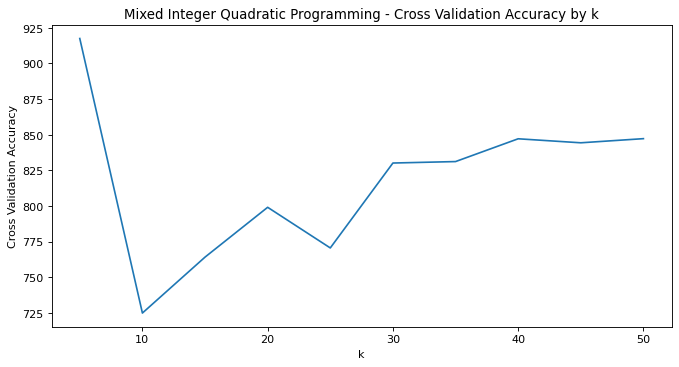

Minimum cross validation error is obtained for k = 10.0


In [11]:
display(output_df_miqp)

plt.figure(figsize=(10, 5), dpi=80)
plt.plot(output_df_miqp['k'], output_df_miqp['cross_val_accuracy'])
plt.title('Mixed Integer Quadratic Programming - Cross Validation Accuracy by k')
plt.xlabel('k')
plt.ylabel('Cross Validation Accuracy')
plt.show()

print(f'\033[1mMinimum cross validation error is obtained for k = {k_final}\033[1m' )

### Test Accuracy

In [12]:
# building MIQP model
final_model = create_direct_variable_selection(X_train, y_train, big_m, k_final, time_limit)

# get coefs
variables = final_model.x
miqp_beta = np.array(variables[:X_train.shape[1]])

# getting y_pred
y_pred = miqp_beta @ X_test.T
prediction_error = get_accuracy(y_test, y_pred)

# creating prediction dataframe
df_pred_miqp = pd.DataFrame({'y_actual': y_test, 'y_predicted': y_pred})

display(df_pred_miqp.head())

print(f'\033[1mPrediction error on test set: {prediction_error}\033[0m')

Academic license - for non-commercial use only - expires 2022-08-25
Using license file C:\Users\aritr\gurobi.lic


,y_actual,y_predicted
0,7.107949,6.179859
1,5.796272,5.095243
2,1.598651,3.285595
3,2.532953,3.758485
4,0.590685,-0.332975


Prediction error on test set: 116.82719822762617


## Indirect Variable Selection - Lasso Regression

The Lasso Regression problem is formulated as:

$$ \underset{\beta,z}min\sum_{i=1}^n (\beta_0 + \beta_1x_{i1} + ... + \beta_mx_{im} - y_i)^2 + \lambda\sum_{j=1}^m|\beta_j| $$

We run through each validation set and calculate the sum of squared errors (accuracy) for each lambda, to calculate the lambda value with the minimum error (highest accuracy).

In [13]:
# creating dataframe to record the data
output_df_lr = pd.DataFrame(data=None, columns=['lambda', 'cross_val_accuracy'])
tot_accuracy = []

# creating a list of lambda parameters
lambda_list = [10**i for i in range(-5, 5, 1)]

for l in lambda_list:
    print('Running for lambda: ', l)
    accuracy = []
    coefficients_list = []
    for train_idx, val_idx in cross_val_list:
        
        # creating train and test data
        x, y = X_train[train_idx, 1:], y_train[train_idx]
        x_val, y_val = X_train[val_idx, 1:], y_train[val_idx]
        
        # fitting the model
        lasso = Lasso(alpha=l)
        lasso.fit(x, y)
        
        # predicting and getting accuracy
        y_pred = lasso.predict(x_val)
        prediction_error = get_accuracy(y_val, y_pred)
        
        # appending the output
        accuracy.append(prediction_error) 
    
    # appending for storing in df
    tot_accuracy.append(np.sum(accuracy))
    
output_df_lr['lambda'] = lambda_list
output_df_lr['cross_val_accuracy'] = tot_accuracy

lambda_final = output_df_lr.loc[output_df_lr['cross_val_accuracy'].idxmin()]['lambda']

Running for lambda:  1e-05
Running for lambda:  0.0001
Running for lambda:  0.001
Running for lambda:  0.01
Running for lambda:  0.1
Running for lambda:  1
Running for lambda:  10
Running for lambda:  100
Running for lambda:  1000
Running for lambda:  10000


### Plot of Validation Error vs Lambda

,lambda,cross_val_accuracy
0,0.00001,847.002294
1,0.00010,845.983748
2,0.00100,836.904951
3,0.01000,778.400013
4,0.10000,699.644522
5,1.00000,2106.081819
6,10.00000,4943.255428
7,100.00000,4943.255428
8,1000.00000,4943.255428
9,10000.00000,4943.255428


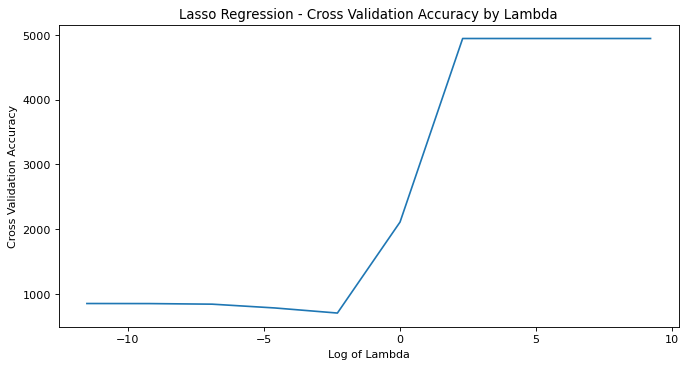

Minimum cross validation error is obtained for lambda = 0.1


In [14]:
display(output_df_lr)

plt.figure(figsize=(10, 5), dpi=80)
plt.plot(np.log(output_df_lr['lambda']), output_df_lr['cross_val_accuracy'])
plt.title('Lasso Regression - Cross Validation Accuracy by Lambda')
plt.xlabel('Log of Lambda')
plt.ylabel('Cross Validation Accuracy')
plt.show()

print(f'\033[1mMinimum cross validation error is obtained for lambda = {lambda_final}\033[1m' )

### Test Accuracy

In [15]:
# fitting the model
lasso = Lasso(alpha=lambda_final)
lasso.fit(X_train[:, 1:], y_train)

# predicting and getting accuracy
y_pred = lasso.predict(X_test[:, 1:])
prediction_error = get_accuracy(y_test, y_pred)

# creating prediction dataframe
df_pred_lasso = pd.DataFrame({'y_actual': y_test, 'y_predicted': y_pred})

display(df_pred_lasso.head())

print(f'\033[1mPrediction error on test set: {prediction_error}\033[0m')

,y_actual,y_predicted
0,7.107949,6.012715
1,5.796272,4.909449
2,1.598651,3.149508
3,2.532953,3.524884
4,0.590685,-0.382678


Prediction error on test set: 117.99758423595785


## Summary and Comparision

We plot the coefficients for both MIQP and Lasso to evaluate the effectiveness of Variable Selection between the 2.

In [16]:
lasso_beta = np.insert(lasso.coef_, 0, lasso.intercept_, axis=0)
final_beta_df = pd.DataFrame(data={'variable': ['intercept'] + list(train.columns[1:]),
                                   'miqp_beta': miqp_beta, 'lasso_beta': lasso_beta})
df_pred = df_pred_miqp.merge(df_pred_lasso, on = 'y_actual', suffixes = ('_miqp', '_lasso'))

,y_actual,y_predicted_miqp,y_predicted_lasso
0,7.107949,6.179859,6.012715
1,5.796272,5.095243,4.909449
2,1.598651,3.285595,3.149508
3,2.532953,3.758485,3.524884
4,0.590685,-0.332975,-0.382678
5,-6.108818,-5.142737,-4.794720
6,-1.993021,-3.144544,-2.789680
7,-1.982904,-1.238063,-1.430238
8,0.134034,1.385111,1.421764
9,-0.728690,-0.441739,-0.279275


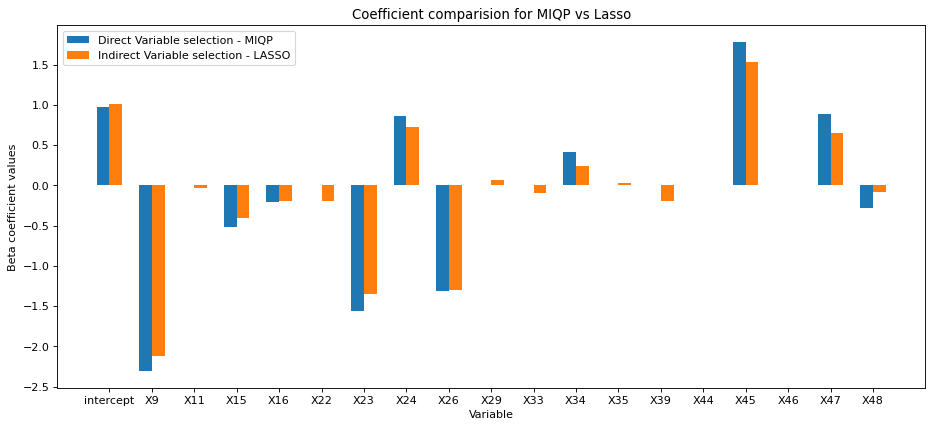

In [17]:
# displaying comparison dataframe
display(df_pred)

# plotting different firm allocation
plt.figure(figsize=(14, 6), dpi=80)
final_beta_df_viz = final_beta_df[(final_beta_df['miqp_beta'] != 0) | (final_beta_df['lasso_beta'] != 0)]

width = 0.3
ind = np.arange(len(final_beta_df_viz))
plt.xticks(ind + width / 2, final_beta_df_viz['variable'])
plt.bar(ind, final_beta_df_viz['miqp_beta'], label='Direct Variable selection - MIQP', width=width)
plt.bar(ind + width, final_beta_df_viz['lasso_beta'], label='Indirect Variable selection - LASSO', width=width)

plt.xlabel('Variable')
plt.ylabel('Beta coefficient values')
plt.title('Coefficient comparision for MIQP vs Lasso')
plt.legend()
plt.savefig('coefficient_comparision_for_miqpvslasso.jpeg')
plt.show()

**Direct variable selection approach using MIQP gives better test results than Lasso.**

This is validated from the above plot, where MIQP reduces more coefficients to exactly 0. 